<a href="https://colab.research.google.com/github/salmonin-o3o/ESAA_study/blob/main/ESAA1007_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 03. 앙상블 학습
### 앙상블 학습 개요
앙상블 학습(Ensemble Laarning)을 통한 분류는 여러 개의 분류기(Classifier)를 생성하고 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법을 말한다.

앙상블 학습의 유형은 전통적으로 보팅(Voting), 배깅(Bagging),부스팅(Boosting)의 세 가지로 나눌 수 있으며, 이 외에도 스태깅을 포함한 다양한 앙상블 방법이 있다. 보팅은 일반적으로 서로 다른 알고리즘을 가진 분류기를 결합하는 것이고, 배깅은 각각의 분류기가 모두 같은 유형의 알고리즘 기반이지만, 데이터 샘플링을 서로 다르게 가져가면서 학습을 수행해 보팅을 수행하는 것이다. 대표적인 배깅 방식이 바로 랜덤 포레스트 알고리즘이다.

배깅에서 개별 분류기에 할당된 학습 데이터는 원본 학습 데이터를 샘플링해 추출하는데, 이렇게 개별 Classifier에게 데이터를 샘플링해서 추출하는 방식을 부트스트래핑(Boostrapping) 분할 방식이라고 부른다. 이때 데이터 세트 간에 중첩을 허용한다.

부스팅은 여러 개의 분류기가 순차적으로 학습을 수행하되, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서는 올바르게 예측할 수 있도록 다음 분류기에게는 가중치(weight)를 부여하면서 학습과 예측을 진행하는 것이다. 대표적인 부스팅 모듈로 그래디언트 부스트, XGBoost, LightGBM이 있다.

스태깅은 여러 가지 다른 모델의 예측 결괏값을 다시 학습 데이터로 만들어서 다른 모델로 재학습시켜 결과를 예측하는 방법이다.

### 보팅 유형 - 하드 보팅(Hard Voting)과 소프트 보팅(Soft Voting)
하드 보팅은 다수결과 비슷하다. 예측한 결괏값들 중 다수의 분류기가 결정한 예측값을 최종 보팅 결괏값으로 선정하는 것이다.

소프트 보팅은 분류기들의 레이블 값 결정 확률을 모두 더하고 이를 평균해서 이들 중 확률이 가장 높은 레이블 값을 최종 보팅 결괏값으로 선정한다. 일반적으로 소프트 보팅을 적용한다.

### 보팅 분류기(Voting Classifier)

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [2]:
  # 개별 모델은 로지스틱 회귀와 KNN임.
  lr_clf = LogisticRegression(solver='liblinear')
  knn_clf = KNeighborsClassifier(n_neighbors=8)

  # 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
  vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)], voting='soft')

  X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

  # VotingClassifier 학습/예측/평가.
  vo_clf.fit(X_train, y_train)
  pred = vo_clf.predict(X_test)
  print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

  # 개별 모델의 학습/예측/평가
  classifiers = [lr_clf, knn_clf]
  for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


## 04. 랜덤 포레스트
### 랜덤 포레스트의 개요 및 실습


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
from google.colab import drive
drive.mount('/content/drive')
feature_name_df = pd.read_csv('/content/drive/My Drive/pythonprogramming/ESAA/human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10ro만 추출:', feature_name[:10])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
전체 피처명에서 10ro만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [4]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [5]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [6]:
import pandas as pd

def get_human_dataset():

  # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
  feature_name_df = pd.read_csv('/content/drive/My Drive/pythonprogramming/ESAA/human_activity/features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

  # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성.
  new_feature_name_df = get_new_feature_name_df(feature_name_df)

  # DataFrame에 피처명으 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

  # 학습 피처 데이터세트와 테스트 피처 세트를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
  X_train = pd.read_csv('/content/drive/My Drive/pythonprogramming/ESAA/human_activity/train/X_train.txt', sep='\s+', names=feature_name)
  X_test = pd.read_csv('/content/drive/My Drive/pythonprogramming/ESAA/human_activity/test/X_test.txt', sep='\s+', names=feature_name)

  # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
  y_train = pd.read_csv('/content/drive/My Drive/pythonprogramming/ESAA/human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
  y_test = pd.read_csv('/content/drive/My Drive/pythonprogramming/ESAA/human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])

  # 로드된 학습/테스트용 DataFrame을 모두 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

<ipython-input-5-9a931926f253>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()를 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9196


### 랜덤 포레스트 하이퍼 파라미터 및 튜닝
트리 기반의 앙상블 알고리즘의 단점은 하이퍼 파라미터가 많다는 것이다.
- n_estimators: 결정 트리의 개수 지정.
- max_features: 결정 트리의 파라미터와 같지만, sqrt라는 점이 다르다.
- max_depth, min_samples_leaf, min_samples_split: 결정 트리의 파라미터와 똑같이 적용.

In [8]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth':[8, 16, 24],
    'min_samples_leaf':[1,6,12],
    'min_samples_split':[2, 8, 16]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도: 0.9165


In [9]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9260


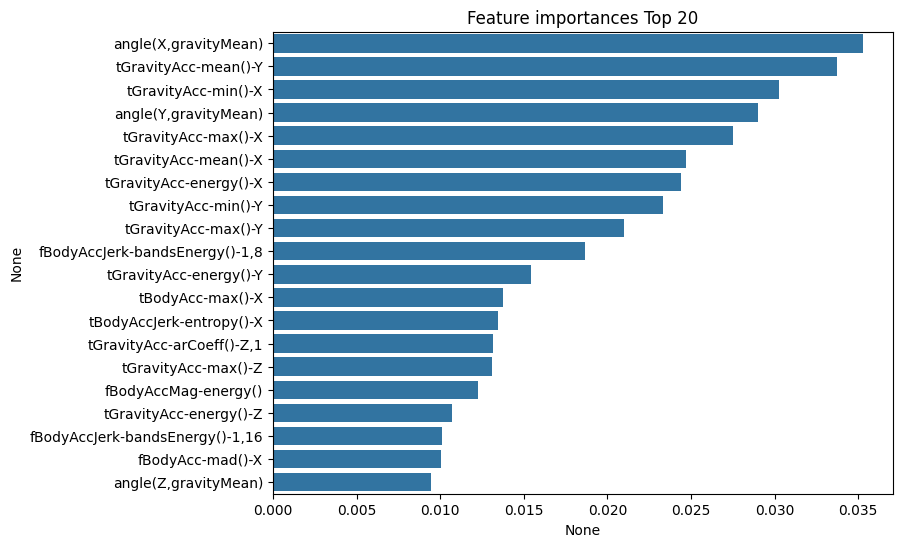

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## 05. GBM(Gradient Boosting Machine)
### GBM의 개요 및 실습
부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식이다. 부스팅의 대표적인 구현은 AdaBoost(Adaptive boosting)와 그래디언트 부스트가 있다.

GBM은 분류는 물론이고 회귀도 가능하다.

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f}초'.format(time.time() - start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 1241.6초


### GBM 하이퍼 파라미터 소개
- loss: 경사 하강법에서 사용할 비용 함수를 지정.
- learning_rate: GBM이 학습을 진행할 떄마다 적용하는 학습률. Weak learner가 순차적으로 오류값을 보정해 나가는 데 적용하는 계수이다. 너무 작으면 성능이 놓아지지만 수행시간이 오래 걸린다. 너무 크면 성능이 떨어지지만 빠른 수행이 가능하다.
- n_estimators: weak learner의 개수.
- subsample: weak learner가 학습에 사용하는 데이터의 샘플링 비율.

## 06. XGBoost(eXtra Gradient Boost)
### XGBoost 개요
- 뛰어난 예측 성능
- GBM 대비 빠른 수행 시간
- 과적합 규제
- Tree pruning
- 자체 내장된 교차 검증
- 결손값 자체 처리

초기의 독자적인 XGBoost 프레임워크 기반의 파이썬 래퍼 XGBoost 모듈과, 사이킷런과 연동되는 모듈인 사이킷런 래퍼 XGBoost 모듈을 사용할 때에는 몇 가지 주의할 점이 있다.

### XGBoost 설치하기

In [12]:
# pip install xgboost==1.5.0

In [13]:
import xgboost as xgb
from xgboost import XGBClassifier

### 파이썬 래퍼 XGBoost 하이퍼 파라미터
- 일반 파라미터
- 부스트 파라미터
- 학습 태스크 파라미터


#### 주요 일반 파라미터
- booster
- silent
- nthread

#### 주요 부스터 파라미터
- eta [default=0.3, alias: learning_rate]
- num_boost_rounds: GBM의 n_estimators와 같은 파라미터.
- min_child_weight[default=1]: 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의 weight 총합. 클수록 가지 분할을 자제.
- gamma [default=0, alias: min_split_loss]: 트리의 리프 노드를 추가적으로 나눌지를 결정할 최소 손실 감소 값. 값이 클수록 과적합 감소 효과가 있음.
- max_depth[default=6]
- sub_sample[default=1]: GBM의 subsample과 동일.
- colsample_bytree[default=1]: GBM의 max_features와 유사.
- lambda [default=1, alias: reg_lambda]
- alpha [default=0, alias: reg_alpha]
- scale_pos_weight [default=1]:특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터.

#### 학습 태스크 파라미터
- objective: 최솟값을 가져야 할 손실 함수 정의.
- binary:logistic: 이진 분류일 때 적용
- multi:softmax: 다중 분류일 때 적용
- multi:softprob: multi:softmax와 비슷. 개별 레이블 클래스의 해당되는 예측 확률을 반환,
- eval_metric: 검증에 사용되는 함수를 정의.(rmse, mae, logloss, error, merror, mlogloss, auc)

*과적합 문제가 심각하다면...?*

eta값을 낮추고 num_round(n_estimator)을 높인다.

max_depth 값을 낮춘다.

min_child_weight 값을 높인다.

gamma 값을 높인다.

subsample이나 colsample_bytree를 조정한다.

그 외에도, XGBoost는 자체적으로 교차 검증, 성능 평가, 피처 중요도 등의 시각화 기능이 있으며, 조기 중단 기능도 있다.

In [14]:
import xgboost

print(xgboost.__version__)

1.5.0


### 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측

In [3]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [16]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [4]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출.
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
# 검증 성능 평가와 조기 중단을 수행해 보기 위함.
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


XGBoost는 전용 데이터 객체인 DMatrix를 사용한다. 따라서 Numpy 또는 Pandas로 되어 있는 학습용, 검증. 테스트용 데이터 세트를 전부 전용의 데이터 객체인 DMatrix로 생성하여 모델에 입력해 줘야 한다.

In [8]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안 될 경우 X_train.values로 넘파이 변환.
# 학습, 검증, 테스트용 DMatrix를 생성.
dtr = xgb.DMatrix(data=X_tr.values, label=y_tr)
dval = xgb.DMatrix(data=X_val.values, label=y_val)
dtest = xgb.DMatrix(data=X_test.values, label=y_test)

In [10]:
params = { 'max_depth':3,
           'eta': 0.05,
           'objective':'binary:logistic',
           'eval_metric':'logloss'
           }
num_rounds = 400

조기 중단의 성능 평가는 주로 별도의 검증 데이터 세트를 이용한다. 조기 중단을 수행하기 위해서는 반드시 평가용 데이터 세트 지정과 eval_metric을 함께 설정해야 한다. Xgboost는 반봅마다 지정된 평가용 데이터 세트에서 eval_metric의 지정된 평가 지표로 예측 오류를 측정한다.

- 평가용 데이터 세트는 학습과 평가용 데이터 세트를 명기하는 개별 튜플을 가지는 리스트 형태로 설정. ex. [(drt.'train').(dval.'eval')]
- eval_metric은 평가 세트에 적용할 성능 평가 방법. 분류일 경우 주로 'error','logloss'적용.

In [11]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval'로 명기합니다.
eval_list = [(dtr, 'train'),(dval, 'eval')] # 또는 eval_list = [(dval, 'eval')]만 명기해도 무방.

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.62480	eval-logloss:0.63104
[1]	train-logloss:0.58674	eval-logloss:0.60478
[2]	train-logloss:0.55226	eval-logloss:0.58223
[3]	train-logloss:0.52086	eval-logloss:0.56184
[4]	train-logloss:0.49192	eval-logloss:0.54118
[5]	train-logloss:0.46537	eval-logloss:0.52223
[6]	train-logloss:0.44029	eval-logloss:0.50287
[7]	train-logloss:0.41666	eval-logloss:0.48620
[8]	train-logloss:0.39525	eval-logloss:0.46974
[9]	train-logloss:0.37542	eval-logloss:0.45497
[10]	train-logloss:0.35701	eval-logloss:0.44131
[11]	train-logloss:0.33982	eval-logloss:0.43134
[12]	train-logloss:0.32297	eval-logloss:0.41972
[13]	train-logloss:0.30725	eval-logloss:0.40902
[14]	train-logloss:0.29327	eval-logloss:0.39883
[15]	train-logloss:0.27946	eval-logloss:0.38968
[16]	train-logloss:0.26691	eval-logloss:0.38150
[17]	train-logloss:0.25473	eval-logloss:0.37368
[18]	train-logloss:0.24385	eval-logloss:0.36666
[19]	train-logloss:0.23338	eval-logloss:0.35994
[20]	train-logloss:0.22320	eval-logloss:0.35374
[2

In [26]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 List 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:', preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [37]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1:0.9677, AUC:0.9937


사이킷런과는 다르게, xgboost 패키지는 plot_importance()를 이용해 f스코어를 기준으로 피처 중요도를 바로 시각화할 수 있다.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

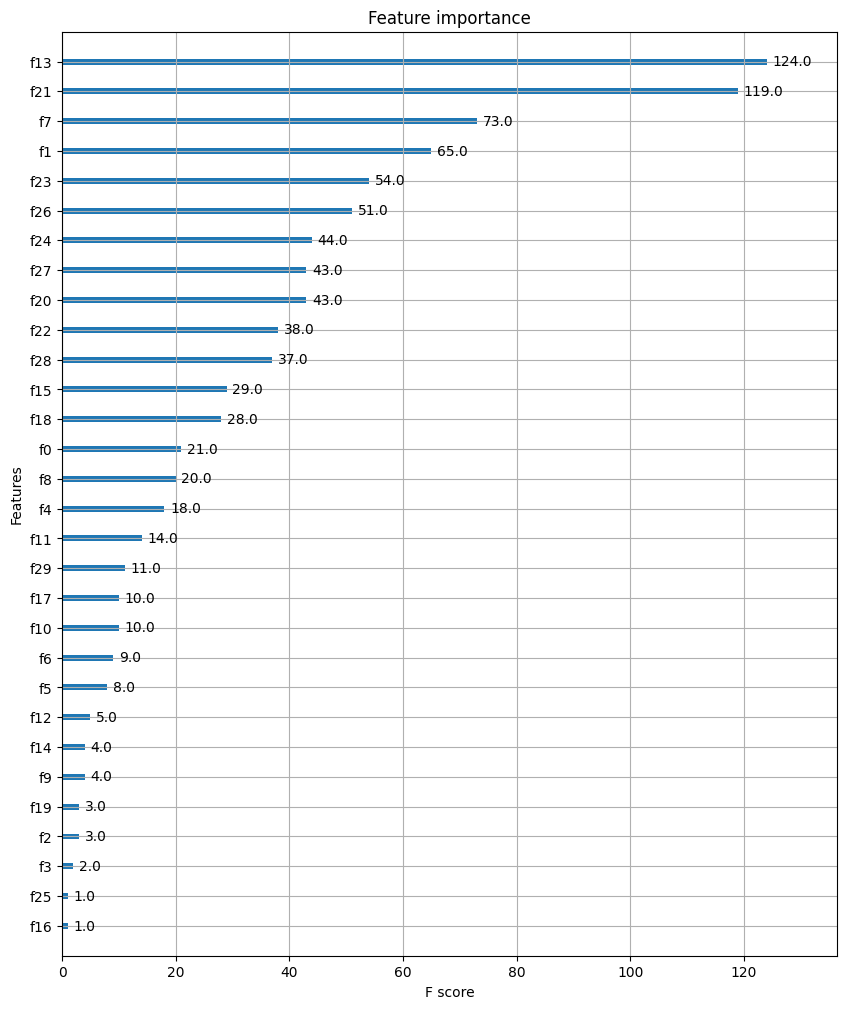

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)
# f0는 첫 번째 피처, f1은 두 번째 피처

xgboost 모듈의 tp_graphiz() API를 이용하면 결정 트리에서 보여준 트리 기반 규칙 구조도 시각화 할 수 있다.

또한, cv() API는 사이킷런의 GridSearchCV와 유사하게 데이터 세트에 대한 교차 검증 수행 후 최적 파라미터를 구할 수 있다.

파라미터
- params(dict): 부스터 파라미터
- dtrain (Matrix): 학습 데이터
- num_boost_round (int): 부스팅 반복 횟수
- nfold (int): CV 폴드 개수.
- strarified (bool): CV 수행 시 stratified sampling 수행 여부
- metrics (string or list of strings): CV 수행 시 모니터링할 성능 평가 지표
- early_stopping_rounds (int): 조기 중단을 활성화 시킴. 반복 횟수 지정.

### 사이킷런 래퍼 XGBoost의 개요 및 적용
XGBClassifier과 XGBRegressor로 나누어진다. 그리고 파이썬 래퍼 XGBoost 파라미터와는 다르게 기존 사이킷런에서 일반적으로 사용하는 하이퍼 파라미터와 호환성을 유지한다.
- eta = learning_rate
- sub_sample = subsample
- lambda = reg_lambda
- alpha = reg_alpha

- num_boost_round = n_estimators



In [14]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

# Warning 메시지를 없애기 eval_metric 값을 XGBClassifier 생성 인자로 입력.
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [16]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1:0.9806, AUC:0.9954


In [14]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss', early_stopping_rounds=50)
evals = [(X_tr, y_tr), (X_val, y_val)] # 맨 앞의 튜플이 학습용, 뒤 튜플이 검증용
xgb_wrapper.fit(X_tr, y_tr, eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

In [17]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740, F1:0.9740, AUC:0.9961


In [19]:
# early_stopping_rounds를 10으로 설정하고 재학습.
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, early_stopping_rounds=10, eval_metric='logloss')
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, eval_set=evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

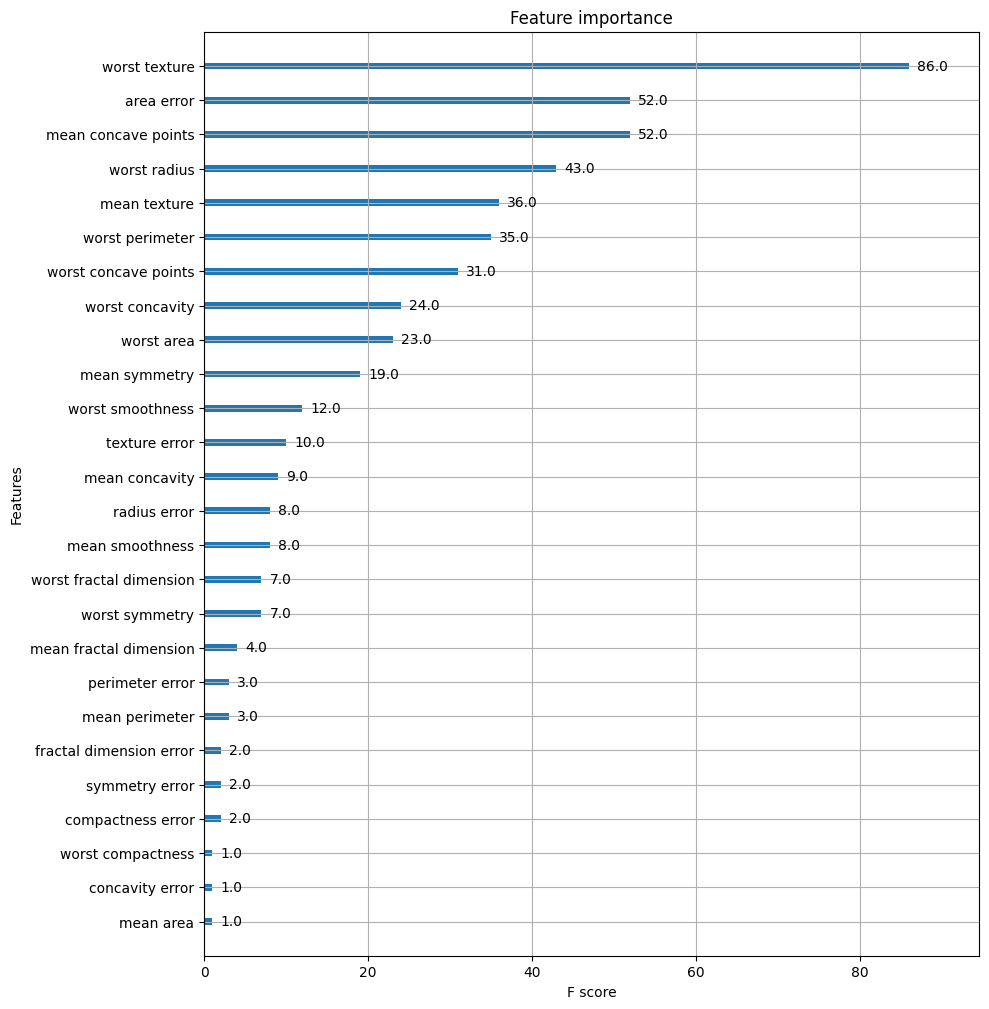

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 래퍼 클래스를 입력해도 무방.
plot_importance(xgb_wrapper, ax=ax)